In [6]:
"""
@author:  <Mohammed Awal Kassim>
@contact: <mkass005@uottawa.ca>
@version: 1.0
@summary: <This is the solution to the second homework of the CSI 5155(Machine Learning) course at the University of Ottawa.>
"""

# Importing useful libraries
import os
import urllib
import numpy as np
import pandas as pd
import imblearn
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from collections import Counter
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, recall_score, precision_score
from sklearn.base import clone
from sklearn.metrics import balanced_accuracy_score

### Declare All Constants

In [9]:
DRUG_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data"
DRUG_STORAGE_PATH = os.path.join("datasets", "drug")
DRUG_FEATURES = ["id", "age", "gender", "education", "country", "ethnicity", "nscore", "escore", "oscore", "ascore", "cscore", "impulsive", "ss"]
DRUG_CLASSES = ["alcohol", "amphet", "amyl", "benzos", "caff", "cannabis", "choc", "coke", "crack", "ecstasy", "heroine", "ketamin", "legalh", "lsd", "meth", "mushrooms", "nicotine", "semer", "vsa"]

LABOR_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/labor-negotiations/"
LABOR_STORAGE_PATH = os.path.join("datasets", "labor")

HEART_URL = "https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci/download?datasetVersionNumber=1"
HEART_STORAGE_PATH = os.path.join("datasets", "heart")

### Fetch data from online repository

In [2]:
def get_data(url, path, file_name):
  """
  Fetches data from the internet given the url
  :param:url: location of dataset on the internet
  :param:path: destination in local environment
  """
  data = os.path.join(path, file_name)
  os.makedirs(path, exist_ok=True)
  urllib.request.urlretrieve(url, data)

### Load data into local workspace

In [3]:
def load_data(path, file_name ):
  """
  Loads data from the local environment
  :param: path: data directory
  :return: pandas dataframe containing data
  """
  data_file = os.path.join(path, file_name)
  return pd.read_csv(data_file,  names = DRUG_FEATURES + DRUG_CLASSES)

### Preprocess data

In [4]:
def preprocess_data(data):
  """
  Performs data preprocessing 
  :param:data: pandas dataframe containing input data
  :return: pandas dataframe containing preprocessed data
  """
  data = data[DRUG_FEATURES + ["semer", "caff"]]
  data = data[data.semer == "CL0"]
  data = data.drop(columns = ["id", "semer"])
  return data

### Scale Features

In [63]:
def scale_features(X):
  data = MinMaxScaler().fit_transform(X)
  return data

### Feature Selection

In [64]:
def select_features(dataset):
  """
  Selects features that are relevant to the classification task using feature importance
  :param: dataset: input data
  :return: a dataframes containing selected features alongside their classes
  """
  class_name = dataset.columns[-1]
  class_name
  #new_classes.remove("semer")
  dataset.shape
  X_train = dataset.drop(dataset.columns[-1], axis=1)
  y_train = dataset[dataset.columns[-1]].copy()

  classifier = LogisticRegression()
  classifier.fit(X_train, y_train)
  model = SelectFromModel(classifier, prefit=True)
  feature_idx = model.get_support()
  feature_names = X_train.columns[feature_idx]
  print(feature_names)
  X_train_new = model.transform(X_train)
  X_train_new = pd.DataFrame(X_train_new, columns=feature_names)
  column_names = list(feature_names) + [class_name]
  X_train_new.reset_index(drop=True, inplace=True)
  y_train.reset_index(drop=True, inplace=True)
  new_data = pd.concat([X_train_new, y_train], axis=1, ignore_index=True)
  new_data.columns = column_names
  new_data.shape


  return new_data

### Binarize labels

In [7]:
def binarize_labels(data):
  """
  Converts the multi class labels to binary
  :param:data: pandas dataframe containing input data
  :return: six dataframes representing consumers of alcohol, amphet, cannabis, chocolate, mushrooms, and nicotine
  """
  label = "caff"
  data[label] = data[label].replace(["CL0", "CL1"], 0)
  data[label] = data[label].replace(["CL2", "CL3", "CL4", "CL5", "CL6"], 1)
  data[label].astype(float)

  # Drop all null values
  data.dropna(inplace=True)
  return data

### Load and inspect data

In [10]:
get_data(DRUG_URL, DRUG_STORAGE_PATH, "drug_consumption.data" )
drug_data = load_data(DRUG_STORAGE_PATH, "drug_consumption.data" )
drug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1885 non-null   int64  
 1   age        1885 non-null   float64
 2   gender     1885 non-null   float64
 3   education  1885 non-null   float64
 4   country    1885 non-null   float64
 5   ethnicity  1885 non-null   float64
 6   nscore     1885 non-null   float64
 7   escore     1885 non-null   float64
 8   oscore     1885 non-null   float64
 9   ascore     1885 non-null   float64
 10  cscore     1885 non-null   float64
 11  impulsive  1885 non-null   float64
 12  ss         1885 non-null   float64
 13  alcohol    1885 non-null   object 
 14  amphet     1885 non-null   object 
 15  amyl       1885 non-null   object 
 16  benzos     1885 non-null   object 
 17  caff       1885 non-null   object 
 18  cannabis   1885 non-null   object 
 19  choc       1885 non-null   object 
 20  coke    

In [7]:
labor_data = pd.read_csv("labor.csv")
heart_data = pd.read_csv("heart_cleveland_upload.csv")

In [8]:
labor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   duration                        57 non-null     object
 1   wage-increase-first-year        57 non-null     object
 2   wage-increase-second-year       57 non-null     object
 3   wage-increase-third-year        57 non-null     object
 4   cost-of-living-adjustment       57 non-null     object
 5   working-hours                   57 non-null     object
 6   pension                         57 non-null     object
 7   standby-pay                     57 non-null     object
 8   shift-differential              57 non-null     object
 9   education-allowance             57 non-null     object
 10  statutory-holidays              57 non-null     object
 11  vacation                        57 non-null     object
 12  longterm-disability-assistance  57 non-null     obje

In [9]:
labor_data.head(10)

,duration,wage-increase-first-year,wage-increase-second-year,wage-increase-third-year,cost-of-living-adjustment,working-hours,pension,standby-pay,shift-differential,education-allowance,statutory-holidays,vacation,longterm-disability-assistance,contribution-to-dental-plan,bereavement-assistance,contribution-to-health-plan,class
0,1,5,?,?,?,40,?,?,2,?,11,average,?,?,yes,?,good
1,2,4.5,5.8,?,?,35,ret_allw,?,?,yes,11,below_average,?,full,?,full,good
2,?,?,?,?,?,38,empl_contr,?,5,?,11,generous,yes,half,yes,half,good
3,3,3.7,4,5,tc,?,?,?,?,yes,?,?,?,?,yes,?,good
4,3,4.5,4.5,5,?,40,?,?,?,?,12,average,?,half,yes,half,good
5,2,2,2.5,?,?,35,?,?,6,yes,12,average,?,?,?,?,good
6,3,4,5,5,tc,?,empl_contr,?,?,?,12,generous,yes,none,yes,half,good
7,3,6.9,4.8,2.3,?,40,?,?,3,?,12,below_average,?,?,?,?,good
8,2,3,7,?,?,38,?,12,25,yes,11,below_average,yes,half,yes,?,good
9,1,5.7,?,?,none,40,empl_contr,?,4,?,11,generous,yes,full,?,?,good


In [14]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [15]:
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [125]:
new_drug_data = preprocess_data(drug_data)
new_drug_data = binarize_labels(new_drug_data)
new_drug_columns = new_drug_data.columns
#new_drug_X = new_drug_data.drop(labels=["caff"], axis=1)
new_drug_data = scale_features(new_drug_data)
new_drug_data.shape

(1877, 13)

In [126]:
new_drug_columns

Index(['age', 'gender', 'education', 'country', 'ethnicity', 'nscore',
       'escore', 'oscore', 'ascore', 'cscore', 'impulsive', 'ss', 'caff'],
      dtype='object')

In [127]:
new_drug_X = pd.DataFrame(new_drug_data)
new_drug_X.columns = new_drug_columns

### Visualize transformed data

In [128]:
new_drug_X.describe()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,caff
count,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000
mean,0.279243,0.499201,0.550853,0.606877,0.264506,0.514049,0.499702,0.529623,0.499905,0.499943,0.469233,0.517741,0.980288
std,0.247874,0.500133,0.214880,0.457053,0.055144,0.148174,0.152327,0.161231,0.143849,0.143989,0.174853,0.240506,0.139047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.412820,0.000000,0.262143,0.413474,0.393845,0.413998,0.412490,0.405822,0.337920,0.388117,1.000000
50%,0.246475,0.000000,0.537681,1.000000,0.262143,0.520448,0.500507,0.527023,0.497505,0.499040,0.428474,0.539559,1.000000
75%,0.409137,1.000000,0.653938,1.000000,0.262143,0.607577,0.597404,0.647268,0.609827,0.584415,0.565343,0.710933,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [129]:
new_drug_X.tail(10)

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,caff
1867,0.000000,0.0,0.412820,0.000000,0.409061,0.506431,0.230828,0.624600,0.390173,0.479394,0.705068,0.825752,1.0
1868,0.246475,0.0,0.412820,0.535185,0.405213,0.492045,0.412116,0.762567,0.367654,0.387201,0.565343,0.619957,1.0
1869,0.000000,0.0,0.225940,0.000000,0.262143,0.735489,0.206510,0.435690,0.244253,0.584415,0.428474,0.825752,1.0
1870,0.000000,0.0,0.653938,0.535185,0.262143,0.506431,0.230828,0.673143,0.390173,0.836768,0.337920,0.465658,1.0
1871,0.000000,0.0,0.412820,0.186098,0.262143,0.396666,0.549172,0.577652,0.456454,0.460156,0.629735,0.710933,1.0
1872,0.000000,1.0,0.412820,0.000000,0.262143,0.336890,0.765875,0.835399,0.609827,0.335773,0.629735,1.000000,1.0
1873,0.000000,0.0,0.412820,0.000000,0.262143,0.477550,0.765875,0.624600,0.609827,0.280854,0.629735,0.710933,1.0
1874,0.246475,1.0,0.653938,0.000000,0.262143,0.682246,0.289795,0.323599,0.244253,0.300104,0.565343,0.388117,1.0
1875,0.000000,1.0,0.412820,0.000000,0.262143,0.649318,0.206510,0.577652,0.266061,0.128634,0.705068,0.825752,1.0
1876,0.000000,0.0,0.412820,0.510396,0.262143,0.444788,0.824839,0.798385,0.660789,0.560031,0.629735,0.825752,1.0


### Select important features

In [130]:
dataset1 = select_features(new_drug_X)
dataset1.info()

Index(['age', 'country', 'ethnicity', 'escore', 'oscore', 'cscore', 'ss'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1877 entries, 0 to 1876
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1877 non-null   float64
 1   country    1877 non-null   float64
 2   ethnicity  1877 non-null   float64
 3   escore     1877 non-null   float64
 4   oscore     1877 non-null   float64
 5   cscore     1877 non-null   float64
 6   ss         1877 non-null   float64
 7   caff       1877 non-null   float64
dtypes: float64(8)
memory usage: 117.4 KB


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


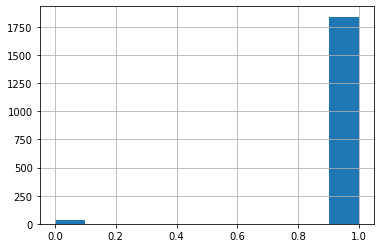

In [131]:
dataset1["caff"].hist()

In [132]:
x = dataset1.drop(columns=["caff"])
y = dataset1[new_drug_columns[-1]].copy()
y

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1872    1.0
1873    1.0
1874    1.0
1875    1.0
1876    1.0
Name: caff, Length: 1877, dtype: float64

In [72]:
# Initialize all four estimators
decision_tree = DecisionTreeClassifier(max_depth=2)
random_forest = RandomForestClassifier(n_estimators=250)
support_vector = SVC(kernel='rbf', random_state=42)
nearest_neighbor = KNeighborsClassifier(n_neighbors=7)

In [73]:
algorithms = {
    'decision trees': decision_tree,
    'random forest': random_forest,
    'support vector': support_vector,
    'nearest neighbor': nearest_neighbor
}

In [168]:
db_results = {}

In [169]:
import sklearn.metrics as metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [170]:

for algorithm in algorithms:
  scores = cross_val_score(algorithms[algorithm], x, y, cv=10, verbose=1, scoring='accuracy')
  score = scores.mean()
  db_results[algorithm] = round(score * 100, 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [183]:
db_results

{'decision trees': 98.03,
 'random forest': 97.87,
 'support vector': 98.03,
 'nearest neighbor': 97.98}

In [184]:
df = pd.DataFrame(db_results.items(), columns=["Algorithm", "Average Accuracy" ])
df.to_csv("cross_validation.csv")

### Oversampling

Random oversampling involves randomly duplicating examples from the minority class and adding them to the training dataset. Examples from the training dataset are selected randomly with replacement. This means that examples from the minority class can be chosen and added to the new balanced training dataset multiple times

In [97]:
print(Counter(y))

Counter({1.0: 1840, 0.0: 37})


In [32]:
# # define oversampling strategy
# oversample = RandomOverSampler(sampling_strategy='minority')
# # fit and apply the transform
# db1_x, db1_y = oversample.fit_resample(x, y)
# # summarize class distribution
# print(Counter(db1_y))

Counter({1.0: 1840, 0.0: 1840})


Both classes now have 1840 instances each

### Retrain all four algorithms on DB1 and perform cross evaluation

### Implement cross validation

scikit-learn doesn't give much control over the cross validation process. To get access to the k-1 sample before applying resampling, we will implement cross validation

Accuracy is not the metric of choice given how heavily skewed the data is. Since we are trying to predict a person's risk of drug consumption(the positive class), recall and precision will be better metrics. However, the data is skewed towards the positive class(i.e positive is majority). This means the precision and recall values may equally be overly optimistic

In [185]:
def oversample_cross_validate(model, X, y, folds):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of accuracy scores
    """
    cv = StratifiedKFold(n_splits=folds)
    oversample = RandomOverSampler(sampling_strategy='minority')
    scores = []

    for train_fold_index, val_fold_index in cv.split(X, y):
        # Create a clone of the model
        model_obj = clone(model)
        # Get the training data
        X_train_fold, y_train_fold = X.iloc[train_fold_index], y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X.iloc[val_fold_index], y[val_fold_index]

        # Upsample only the data in the training section (DB1)
        db1_x, db1_y = oversample.fit_resample(X_train_fold, y_train_fold)

        # Fit the model on the upsampled training data (DB1)
        model_obj = model.fit(db1_x, db1_y)
        # Score the model on the (not sampled) validation data
        score = accuracy_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
    return np.array(scores)

In [186]:
db1_results = {}

for algorithm in algorithms:
  scores = oversample_cross_validate(algorithms[algorithm], x, y, 10)
  score = scores.mean()
  db1_results[algorithm] = round(score * 100, 2)

In [187]:
db1_results

{'decision trees': 46.04,
 'random forest': 97.34,
 'support vector': 72.83,
 'nearest neighbor': 91.58}

In [188]:
df1 = pd.DataFrame(db1_results.items(), columns=["Algorithm", "Average Accuracy" ])

### Under-sampling

Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset.
This has the effect of reducing the number of examples in the majority class in the transformed version of the training dataset. This process can be repeated until the desired class distribution is achieved, such as an equal number of examples for each class

In [189]:
def undersample_cross_validate(model, X, y, folds):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of accuracy scores
    """
    cv = StratifiedKFold(n_splits=folds)
    undersample = RandomUnderSampler(sampling_strategy='majority')
    scores = []

    for train_fold_index, val_fold_index in cv.split(X, y):
        # Create a clone of the model
        model_obj = clone(model)
        # Get the training data
        X_train_fold, y_train_fold = X.iloc[train_fold_index], y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X.iloc[val_fold_index], y[val_fold_index]

        # Under sample only the data in the training section(DB2)
        db2_x, db2_y = undersample.fit_resample(X_train_fold, y_train_fold)

        # Fit the model on the undersampled training data
        model_obj = model.fit(db2_x, db2_y)
        
        # Score the model on the (not sampled) validation data
        score = accuracy_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
    return np.array(scores)

In [46]:
# print(Counter(y))
# # define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy='majority')
# # fit and apply the transform
# db2_x, db2_y = undersample.fit_resample(x, y)
# # summarize class distribution
# print(Counter(db2_y))

Counter({1.0: 1840, 0.0: 37})
Counter({0.0: 37, 1.0: 37})


Both classes now have 37 instances each

### Retrain all four algorithms on DB2 and perform cross validation

In [190]:
db2_results = {}

for algorithm in algorithms:
  scores = undersample_cross_validate(algorithms[algorithm], x, y, 10)
  score = scores.mean()
  db2_results[algorithm] = round(score * 100, 2)

db2_results

{'decision trees': 48.42,
 'random forest': 62.44,
 'support vector': 52.63,
 'nearest neighbor': 61.86}

In [191]:
df2 = pd.DataFrame(db2_results.items(), columns=["Algorithm", "Average Accuracy" ])

### MLP and  Gradient Boosting

In [74]:
algorithms2 = {
    "gb": GradientBoostingClassifier(),
    "mlp": MLPClassifier(max_iter=100)
}
# max_iter is the number of epochs, not a hyper parameter

### Parameter Search

For the gradient boosting classifier, we have to choose the optimal values for the model parameters to get the best accuracy. These parameters include but not limited to the following

 - Number of trees(where we use trees as the estimator)
 - Maximum depth of each tree
 - Learning rate


For the MLP, we have to choose the optimal values for the following parameters to get the best accuracy
  - Learning rate
  - Number of hidden layers
  - Optimization algorithm(solver)
  - alpha(strength of L2 regularization term)
  - activation function
   

### Tuning parameters for the multi-layer perceptron

In [75]:
parameter_distribution = {
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'hidden_layer_sizes': [(10,), (20,), (50,), (100)],
    'activation': ['tanh', 'relu']
}

Using grid search to get the best parameters for 10 fold cross validation

In [76]:
search = GridSearchCV(algorithms2["mlp"], parameter_distribution, n_jobs=-1, cv=10, verbose=1)

Find best parameters for D, DB1 and DB2

In [197]:
search.fit(x, y)
print(f"Best parameters for D: {search.best_params_}")

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Best parameters for D: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'sgd'}


In [198]:
search.best_score_

0.9802935487541244

In [199]:
# Random oversampler produces DB1 from X and Y
# We use a pipeline to prevent upsampling the validation set
# Similar to the oversample_cross_validate() custom function above

oversample = RandomOverSampler(sampling_strategy='minority')
imba_pipeline = make_pipeline(oversample, 
                              algorithms2["mlp"])
scores = cross_val_score(imba_pipeline, x, y, scoring='accuracy', cv=10)
scores.mean()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

0.7149817954261009

In [200]:
undersample = RandomUnderSampler(sampling_strategy='majority')
imba_pipeline = make_pipeline(undersample, 
                              algorithms2["mlp"])
scores = cross_val_score(imba_pipeline, x, y, scoring='accuracy', cv=10)
scores.mean()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

0.5743486175901695

### Tuning parameters for gradient boosting

In [77]:
gb_parameters = {
    "n_estimators":[5,50,100,250],
    "max_depth":[3,5,7],
    "learning_rate":[0.01,0.1,1]
}

In [78]:
gb_search = GridSearchCV(algorithms2["gb"], gb_parameters, n_jobs=-1, cv=10, verbose=1)

In [203]:
gb_search.fit(x, y)
gb_search.best_params_
gb_search.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


0.9802935487541244

To tune parameters using DB1 and DB2, we will use a pipeline for both oversampling and undersampling

Using the pipeline helps maintain independence between training and validation set during oversampling and crossvalidation 

In [204]:
oversample = RandomOverSampler(sampling_strategy='minority')
imba_pipeline = make_pipeline(oversample, 
                              algorithms2["gb"])
scores = cross_val_score(imba_pipeline, x, y, scoring='accuracy', cv=10)
scores.mean()

0.8913044714984639

In [205]:
undersample = RandomUnderSampler(sampling_strategy='majority')
imba_pipeline = make_pipeline(undersample, 
                              algorithms2["gb"])
scores = cross_val_score(imba_pipeline, x, y, scoring='accuracy', cv=10)
scores.mean()

0.6291557628854251

### 10 fold cross validation on heart disease data

In [65]:
heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


Apply normalization and feature selection

In [66]:
heart_columns = heart_data.columns
scaled_heart_data = scale_features(heart_data)
scaled_heart_data = pd.DataFrame(scaled_heart_data, columns=heart_columns)
scaled_heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,0.833333,1.0,0.0,0.622642,0.246575,1.0,1.0,0.458015,0.0,0.016129,0.5,0.333333,0.0,0.0
1,0.833333,0.0,0.0,0.433962,0.257991,0.0,0.0,0.610687,0.0,0.290323,0.0,0.666667,0.0,0.0
2,0.770833,0.0,0.0,0.528302,0.228311,0.0,0.0,0.328244,0.0,0.419355,1.0,0.000000,0.0,0.0
3,0.750000,1.0,0.0,0.415094,0.356164,1.0,1.0,0.786260,0.0,0.225806,0.5,0.333333,0.0,1.0
4,0.729167,1.0,0.0,0.150943,0.194064,0.0,1.0,0.557252,1.0,0.290323,0.5,0.000000,0.0,0.0


In [67]:
heart_data = select_features(scaled_heart_data)
heart_data.info()

Index(['cp', 'thalach', 'oldpeak', 'ca', 'thal'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cp         297 non-null    float64
 1   thalach    297 non-null    float64
 2   oldpeak    297 non-null    float64
 3   ca         297 non-null    float64
 4   thal       297 non-null    float64
 5   condition  297 non-null    float64
dtypes: float64(6)
memory usage: 14.0 KB


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [69]:
heart_x = heart_data.drop(columns=["condition"])
heart_y = heart_data[heart_columns[-1]].copy()

Train and validate heart data on first 4 algorithms

In [70]:
heart_results = {}

for algorithm in algorithms:
  scores = cross_val_score(algorithms[algorithm], heart_x, heart_y, cv=10, verbose=1)
  score = scores.mean()
  heart_results[algorithm] = score

heart_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


{'decision_trees': 0.6289655172413793,
 'random_forest': 0.7808045977011494,
 'support_vector': 0.8049425287356321,
 'nearest_neighbor': 0.8116091954022989}

### Parameter search for MLP  and GB on heart data

In [207]:
search.fit(heart_x, heart_y)
search.best_params_
search.best_score_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.8350574712643679

In [208]:
gb_search.fit(heart_x, heart_y)
gb_search.best_params_
gb_search.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


0.7981609195402299

In [10]:
labor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   duration                        57 non-null     object
 1   wage-increase-first-year        57 non-null     object
 2   wage-increase-second-year       57 non-null     object
 3   wage-increase-third-year        57 non-null     object
 4   cost-of-living-adjustment       57 non-null     object
 5   working-hours                   57 non-null     object
 6   pension                         57 non-null     object
 7   standby-pay                     57 non-null     object
 8   shift-differential              57 non-null     object
 9   education-allowance             57 non-null     object
 10  statutory-holidays              57 non-null     object
 11  vacation                        57 non-null     object
 12  longterm-disability-assistance  57 non-null     obje

The combined train and test labor-relations data has a total of 57 instances with missing values. dropping any of these instances is not an option given the size of the dataset

In [34]:
new_relations = labor_data.replace('?', np.NaN)

In [35]:
new_relations.head()

,duration,wage-increase-first-year,wage-increase-second-year,wage-increase-third-year,cost-of-living-adjustment,working-hours,pension,standby-pay,shift-differential,education-allowance,statutory-holidays,vacation,longterm-disability-assistance,contribution-to-dental-plan,bereavement-assistance,contribution-to-health-plan,class
0,1,5,NaN,NaN,NaN,40,NaN,NaN,2,NaN,11,average,NaN,NaN,yes,NaN,good
1,2,4.5,5.8,NaN,NaN,35,ret_allw,NaN,NaN,yes,11,below_average,NaN,full,NaN,full,good
2,NaN,NaN,NaN,NaN,NaN,38,empl_contr,NaN,5,NaN,11,generous,yes,half,yes,half,good
3,3,3.7,4,5,tc,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,yes,NaN,good
4,3,4.5,4.5,5,NaN,40,NaN,NaN,NaN,NaN,12,average,NaN,half,yes,half,good


In [36]:
new_relations = new_relations.fillna(method='ffill').fillna(method='bfill')

In [37]:
new_relations.tail()

,duration,wage-increase-first-year,wage-increase-second-year,wage-increase-third-year,cost-of-living-adjustment,working-hours,pension,standby-pay,shift-differential,education-allowance,statutory-holidays,vacation,longterm-disability-assistance,contribution-to-dental-plan,bereavement-assistance,contribution-to-health-plan,class
52,3,3.5,4,4.5,tcf,35,empl_contr,14,5,yes,13,generous,yes,half,yes,full,good
53,3,4,3.5,4.5,none,40,empl_contr,14,6,yes,11,average,yes,full,yes,full,good
54,3,5,4.4,4.5,none,38,empl_contr,10,6,yes,11,generous,yes,full,yes,full,good
55,3,5,5,5,none,40,empl_contr,10,6,yes,12,average,yes,half,yes,half,good
56,3,6,6,4,none,35,empl_contr,10,14,yes,9,generous,yes,full,yes,full,good


In [38]:
# Define data types for columns
types = {
    'duration': 'float',
    'wage-increase-first-year': 'float',
    'wage-increase-second-year': 'float',
    'wage-increase-third-year': 'float',
    'working-hours': 'float',
    'standby-pay': 'float',
    'shift-differential': 'float',
    'statutory-holidays': 'float',    
}


In [39]:
# Convert columns
new_relations = new_relations.astype(types)

In [40]:
numeric = ['duration',
    'wage-increase-first-year',
    'wage-increase-second-year',
    'wage-increase-third-year',
    'working-hours',
    'standby-pay',
    'shift-differential',
    'statutory-holidays']

In [41]:
column_names = new_relations.columns
column_names

Index(['duration', 'wage-increase-first-year', 'wage-increase-second-year',
       'wage-increase-third-year', 'cost-of-living-adjustment',
       'working-hours', 'pension', 'standby-pay', 'shift-differential',
       'education-allowance', 'statutory-holidays', 'vacation',
       'longterm-disability-assistance', 'contribution-to-dental-plan',
       'bereavement-assistance', 'contribution-to-health-plan', 'class'],
      dtype='object')

In [42]:
categorical = list(set(column_names) - set(numeric))
categorical

['contribution-to-dental-plan',
 'pension',
 'contribution-to-health-plan',
 'class',
 'bereavement-assistance',
 'longterm-disability-assistance',
 'cost-of-living-adjustment',
 'vacation',
 'education-allowance']

In [43]:
new_relations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   duration                        57 non-null     float64
 1   wage-increase-first-year        57 non-null     float64
 2   wage-increase-second-year       57 non-null     float64
 3   wage-increase-third-year        57 non-null     float64
 4   cost-of-living-adjustment       57 non-null     object 
 5   working-hours                   57 non-null     float64
 6   pension                         57 non-null     object 
 7   standby-pay                     57 non-null     float64
 8   shift-differential              57 non-null     float64
 9   education-allowance             57 non-null     object 
 10  statutory-holidays              57 non-null     float64
 11  vacation                        57 non-null     object 
 12  longterm-disability-assistance  57 non

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfd3da9c90>,
      dtype=object)

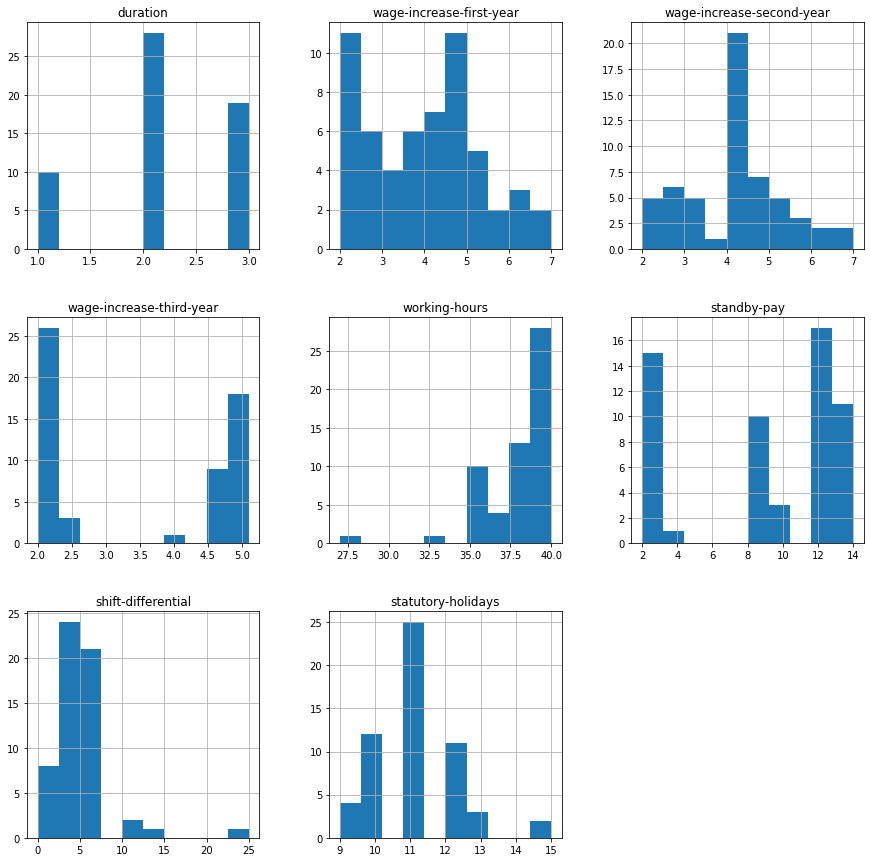

In [21]:
new_relations.hist(figsize=(15, 15))

In [44]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [60]:
new_relations = new_relations.apply(LabelEncoder().fit_transform)

In [66]:
new_relations.head()

,duration,wage-increase-first-year,wage-increase-second-year,wage-increase-third-year,cost-of-living-adjustment,working-hours,pension,standby-pay,shift-differential,education-allowance,statutory-holidays,vacation,longterm-disability-assistance,contribution-to-dental-plan,bereavement-assistance,contribution-to-health-plan,class
0,0,11,11,7,1,7,2,4,2,1,2,0,1,0,1,0,1
1,1,9,11,7,1,2,2,4,2,1,2,1,1,0,1,0,1
2,1,9,11,7,1,5,0,4,5,1,2,2,1,1,1,1,1
3,2,6,4,7,1,5,0,4,5,1,2,2,1,1,1,1,1
4,2,9,6,7,1,7,0,4,5,1,3,0,1,1,1,1,1


### Scaling and feature selection on labor dataset

In [68]:
# scale labor relations data
# Select important features
columns = new_relations.columns
new_labor_data = scale_features(new_relations)
new_labor_data = pd.DataFrame(new_labor_data, columns=columns)
new_labor_data = select_features(new_labor_data)

Index(['wage-increase-first-year', 'wage-increase-second-year',
       'working-hours', 'standby-pay', 'statutory-holidays',
       'contribution-to-dental-plan'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [82]:
new_labor_data.head()

,wage-increase-first-year,wage-increase-second-year,working-hours,standby-pay,statutory-holidays,contribution-to-dental-plan,class
0,0.6875,0.785714,1.000000,0.666667,0.4,0.0,1.0
1,0.5625,0.785714,0.285714,0.666667,0.4,0.0,1.0
2,0.5625,0.785714,0.714286,0.666667,0.4,0.5,1.0
3,0.3750,0.285714,0.714286,0.666667,0.4,0.5,1.0
4,0.5625,0.428571,1.000000,0.666667,0.6,0.5,1.0


In [70]:
x = new_labor_data.drop(columns=["class"])
y = new_labor_data[columns[-1]].copy()

In [79]:
labor_results = {}

for algorithm in algorithms:
  scores = cross_val_score(algorithms[algorithm], x, y, cv=10, verbose=1, scoring='accuracy')
  score = scores.mean()
  labor_results[algorithm] = round(score * 100, 2)

labor_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


{'decision trees': 87.33,
 'random forest': 77.67,
 'support vector': 86.0,
 'nearest neighbor': 86.0}

In [80]:
search.fit(x, y)
search.best_params_
search.best_score_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.9333333333333333

In [81]:
gb_search.fit(x, y)
gb_search.best_params_
gb_search.best_score_

Fitting 10 folds for each of 36 candidates, totalling 360 fits


0.8266666666666668

In [91]:
results_combined = pd.read_csv("output.csv")
results_combined.head(6)

,Algorithm,DB,DB1,DB2,Heart,Labor
0,Decision Trees,98.03,46.04,48.42,62.90,87.33
1,Random Forests,97.87,97.34,62.44,78.08,77.67
2,Support Vectors,98.03,72.83,52.63,80.49,86.00
3,Nearest Neighbors,97.98,91.58,61.86,81.16,86.00
4,MLP,98.03,71.50,57.43,83.50,93.33
5,Gradient Boosting,98.03,89.13,62.92,79.82,82.67


### Tests of statistical significance

In [86]:
from scipy.stats import friedmanchisquare, wilcoxon
import itertools

results = results_combined.T
results.head(6)

,0,1,2,3,4,5
Algorithm,Decision Trees,Random Forests,Support Vectors,Nearest Neighbors,MLP,Gradient Boosting
DB,98.03,97.87,98.03,97.98,98.03,98.03
DB1,46.04,97.34,72.83,91.58,71.5,89.13
DB2,48.42,62.44,52.63,61.86,57.43,62.92
Heart,62.9,78.08,80.49,81.16,83.5,79.82
Labor,87.33,77.67,86.0,86.0,93.33,82.67


In [106]:
results_combined.loc[1].values.tolist()[1:]

[97.87, 97.34, 62.44, 78.08, 77.67]

In [107]:
f_test = friedmanchisquare(results_combined.iloc[0].values.tolist()[1:],results_combined.iloc[1].values.tolist()[1:],results_combined.iloc[2].values.tolist()[1:], results_combined.iloc[3].values.tolist()[1:], results_combined.iloc[4].values.tolist()[1:], results_combined.iloc[5].values.tolist()[1:])

In [109]:
f_test

FriedmanchisquareResult(statistic=3.3841463414634063, pvalue=0.6409855854007922)

a = 0.05 for 6 algorithms and 5 datasets has a critical value of 10.490